# Computer Vision

# Part 2: Mengurangi Bias dalam Sistem Deteksi Wajah

Pada bagian kedua dari lab ini, kita akan mengeksplorasi dua aspek penting dari pembelajaran mendalam terapan: **deteksi wajah** dan **bias algoritmik**.

Membangun sistem AI yang adil dan bebas bias sangat penting untuk penerimaan jangka panjangnya. Pertimbangkan tugas deteksi wajah: *diberikan sebuah gambar, apakah itu gambar wajah?* Tugas ini tampak sederhana, namun sangat penting, dan ternyata sangat rentan terhadap tingkat bias algoritmik yang signifikan terhadap kelompok demografis tertentu.

Dalam lab ini, kita akan menyelidiki [salah satu pendekatan terbaru yang dipublikasikan](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf) untuk mengatasi bias algoritmik. Kita akan membangun model deteksi wajah yang mempelajari *variabel laten* yang mendasari kumpulan data gambar wajah, dan menggunakan informasi tersebut untuk melakukan *adaptive re-sampling* pada data pelatihan. Dengan cara ini, kita dapat mengurangi bias yang mungkin ada, dan melatih model yang lebih *debiased*.

Jalankan blok kode berikut untuk menampilkan video singkat dari Google yang menjelaskan bagaimana dan mengapa penting untuk mempertimbangkan bias saat bekerja dengan pembelajaran mesin.


In [ ]:
#!pip install comet_ml --quiet
import comet_ml
# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = "COMET_KEY_KAMU"

# Import Tensorflow 2.0
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package
#!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0
assert COMET_API_KEY != "", "Please insert your Comet API Key"

2025-09-03 10:14:04.878635: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 10:14:04.896420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756869244.917468   27826 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756869244.924170   27826 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-03 10:14:04.946569: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## 2.1 Dataset

Dalam lab ini, kita akan menggunakan **tiga dataset**.  
Untuk melatih model deteksi wajah kita, kita membutuhkan **dataset contoh positif** (yaitu gambar yang berisi wajah) dan **dataset contoh negatif** (yaitu gambar yang tidak mengandung wajah).  
Kedua dataset ini akan digunakan untuk melatih model agar dapat mengklasifikasikan gambar sebagai **“wajah”** atau **“bukan wajah.”**

Selain itu, kita juga memerlukan **dataset uji** yang berisi gambar wajah.  
Karena kita ingin meneliti potensi *bias* dari model yang dilatih terhadap kelompok demografis tertentu, maka penting bahwa dataset uji yang digunakan memiliki **representasi yang seimbang** di antara kelompok demografis atau fitur yang kita perhatikan.  
Dalam lab ini, kita akan mempertimbangkan **warna kulit** dan **jenis kelamin (gender)**.

1. **Data latih positif**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) — dataset berskala besar (lebih dari 200 ribu gambar) yang berisi wajah selebriti.  
2. **Data latih negatif**: [ImageNet](http://www.image-net.org/) — berisi banyak gambar dari berbagai kategori. Kita akan mengambil contoh negatif dari berbagai kategori yang **tidak mengandung manusia**.  
   Untuk anotasi warna kulit, digunakan [Fitzpatrick Scale](https://en.wikipedia.org/wiki/Fitzpatrick_scale), yaitu sistem klasifikasi tipe kulit, dengan setiap gambar diberi label **“Lighter” (lebih terang)** atau **“Darker” (lebih gelap)**.

Sekarang, mari kita mulai dengan mengimpor dataset ini.  
Telah disiapkan sebuah *class* yang melakukan sedikit *pre-processing* agar data pelatihan dapat diimpor dalam format yang mudah digunakan.


In [5]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

1263889489/1263889489 ━━━━━━━━━━━━━━━━━━━━ 110s 0us/step
Opening /home/jupyter-sigitpurnomo/.keras/datasets/train_face.h5
Loading data into memory...


Kita dapat melihat ukuran dataset pelatihan dan mengambil satu *batch* dengan ukuran 100:

In [6]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

Cobalah untuk menampilkan beberapa gambar agar kamu bisa melihat seperti apa sebenarnya data pelatihan tersebut!


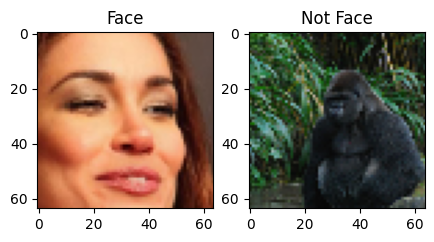

In [ ]:
### Meninjau Dataset Pelatihan CelebA ###

#@title Ubah posisi slider untuk melihat contoh gambar positif (wajah) dan negatif (bukan wajah)! { run: "auto" }

# Memisahkan gambar yang berlabel wajah (label = 1) dan bukan wajah (label = 0)
face_images = images[np.where(labels == 1)[0]]      # Gambar wajah
not_face_images = images[np.where(labels == 0)[0]]  # Gambar bukan wajah

# Mengatur indeks gambar yang akan ditampilkan
# (nilai dapat diubah menggunakan slider untuk melihat contoh berbeda)
idx_face = 23       #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 9    #@param {type:"slider", min:0, max:50, step:1}

# Membuat kanvas berukuran 5x5 inci untuk menampilkan dua gambar
plt.figure(figsize=(5, 5))

# Menampilkan gambar wajah (contoh positif)
plt.subplot(1, 2, 1)                # Membagi kanvas menjadi 1 baris, 2 kolom, posisi 1
plt.imshow(face_images[idx_face])   # Menampilkan salah satu gambar wajah
plt.title("Face")                   # Memberi judul "Face"
plt.grid(False)                     # Menghilangkan garis kisi agar tampilan lebih bersih

# Menampilkan gambar bukan wajah (contoh negatif)
plt.subplot(1, 2, 2)                    # Posisi ke-2 dari subplot
plt.imshow(not_face_images[idx_not_face])  # Menampilkan salah satu gambar bukan wajah
plt.title("Not Face")                    # Memberi judul "Not Face"
plt.grid(False)                          # Menghilangkan garis kisi

# Penjelasan:
# Kode ini digunakan untuk *meninjau data pelatihan CelebA*.
# Dataset dibagi menjadi dua kelompok: gambar wajah dan gambar bukan wajah.
# Dengan bantuan slider, kita bisa mengganti indeks gambar untuk melihat contoh lain.
# Tujuannya adalah agar kita memahami karakteristik visual dari kedua jenis data ini
# sebelum digunakan dalam proses pelatihan model deteksi wajah.

### Memahami Konsep Bias

Ingat bahwa kita akan melatih *classifier* deteksi wajah menggunakan dataset besar dan terkurasi dengan baik — yaitu **CelebA** (untuk gambar wajah) dan **ImageNet** (untuk gambar bukan wajah).  
Setelah itu, kita akan menguji akurasi model tersebut menggunakan dataset uji independen.  
Tujuan kita adalah membangun model yang **dilatih dengan CelebA** *dan* memiliki **akurasi tinggi di dataset uji pada semua kelompok demografis**, sehingga kita dapat menunjukkan bahwa model tersebut **tidak mengandung bias tersembunyi**.

---

### Apa sebenarnya yang dimaksud dengan *bias* dalam konteks ini?

Untuk menjelaskan hal ini secara lebih formal, kita perlu memahami konsep [*variabel laten (latent variables)*](https://en.wikipedia.org/wiki/Latent_variable).  
Variabel laten adalah variabel yang **mempengaruhi atau mendefinisikan dataset**, tetapi **tidak langsung terlihat atau diukur**.  

Dalam konteks pembelajaran mendalam, kita sering berbicara tentang **ruang laten (latent space)** — yaitu *distribusi probabilitas* dari variabel-variabel laten tersebut.  
Ruang ini menggambarkan struktur tersembunyi di balik data, misalnya bentuk wajah, warna kulit, ekspresi, atau pencahayaan.

---

Dengan menggabungkan konsep ini, kita dapat mendefinisikan bahwa sebuah *classifier* dianggap **bias** apabila **keputusan klasifikasinya berubah** setelah diberi informasi tambahan mengenai fitur laten tertentu (misalnya warna kulit atau jenis kelamin).  
Artinya, model tersebut tidak sepenuhnya menilai berdasarkan fitur utama (apakah ada wajah atau tidak), tetapi juga terpengaruh oleh faktor yang seharusnya tidak relevan.

---

**Inti Pemahaman:**
Bagian ini mengajak kita berpikir bahwa bias dalam model bukan sekadar kesalahan teknis, tetapi bisa muncul karena model *secara tidak sadar belajar dari pola tersembunyi (latent)* yang tidak adil terhadap kelompok tertentu.  
Tujuan utama eksperimen di lab ini adalah **mendeteksi dan mengurangi bias tersebut** agar model deteksi wajah bekerja secara adil untuk semua orang.


## 2.2 CNN untuk Deteksi Wajah

Pertama, kita akan **mendefinisikan dan melatih CNN** untuk tugas klasifikasi wajah, kemudian mengevaluasi akurasinya.  
Nantinya, hasil performa model ini akan dibandingkan dengan model *debiased* (model yang telah dikurangi biasnya).  
Model CNN yang digunakan memiliki **arsitektur standar**, terdiri dari beberapa lapisan konvolusi (*convolutional layers*) dengan **normalisasi batch (batch normalization)**, diikuti oleh **dua lapisan fully connected** untuk melakukan *flattening* terhadap hasil konvolusi dan menghasilkan **prediksi kelas** akhir.

---

### Mendefinisikan dan Melatih Model CNN

Seperti yang telah kita lakukan pada bagian pertama dari lab ini, kita akan mendefinisikan model CNN, kemudian **melatihnya menggunakan dataset CelebA dan ImageNet**.  
Proses pelatihannya akan menggunakan kelas [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) dan metode [`tf.GradientTape.gradient`](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient).

---

**Penjelasan Tambahan:**
- **`tf.GradientTape`** digunakan untuk *merekam perhitungan gradien* secara manual. Ini memberi kita fleksibilitas lebih untuk memahami bagaimana model belajar dari data.
- Dengan cara ini, kita bisa lebih mudah **menganalisis pengaruh parameter dan data terhadap bias model**, yang akan berguna saat kita membandingkan model CNN standar dengan model *debiased* nanti.
- Intinya, bagian ini adalah langkah dasar untuk **membangun baseline model deteksi wajah** sebelum kita melakukan langkah *debiasing*.


In [ ]:
### Mendefinisikan Model CNN ###

n_filters = 12  # jumlah dasar filter konvolusi

'''Fungsi untuk mendefinisikan model CNN standar'''
def make_standard_classifier(n_outputs=1):
  # Membuat alias untuk lapisan-lapisan Keras agar penulisan lebih ringkas
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  # Membangun model CNN secara berurutan
  model = tf.keras.Sequential([
    # Lapisan konvolusi pertama
    Conv2D(filters=1*n_filters, kernel_size=5, strides=2),
    BatchNormalization(),

    # Lapisan konvolusi kedua
    Conv2D(filters=2*n_filters, kernel_size=5, strides=2),
    BatchNormalization(),

    # Lapisan konvolusi ketiga
    Conv2D(filters=4*n_filters, kernel_size=3, strides=2),
    BatchNormalization(),

    # Lapisan konvolusi keempat
    Conv2D(filters=6*n_filters, kernel_size=3, strides=2),
    BatchNormalization(),

    # Mengubah hasil konvolusi menjadi vektor satu dimensi
    Flatten(),

    # Dua lapisan fully connected (dense layers)
    Dense(512),
    Dense(n_outputs, activation=None),  # Lapisan output tanpa aktivasi (untuk logit)
  ])
  return model

# Membuat instance model CNN standar
standard_classifier = make_standard_classifier()


Bagian ini untuk melatih CNN

In [ ]:
### Membuat Eksperimen Comet untuk Melacak Proses Pelatihan ###

def create_experiment(project_name, params):
  # Mengakhiri eksperimen sebelumnya (jika ada) agar tidak terjadi bentrok data
  if 'experiment' in locals():
    experiment.end()

  # Menginisialisasi eksperimen Comet baru untuk melacak proses pelatihan model
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,      # Kunci API Comet untuk autentikasi
                  project_name=project_name)  # Nama proyek di dashboard Comet

  # Mencatat (log) seluruh hyperparameter yang digunakan ke dalam eksperimen Comet
  for param, value in params.items():
    experiment.log_parameter(param, value)

  # Memastikan semua data log dikirim ke server Comet
  experiment.flush()

  return experiment

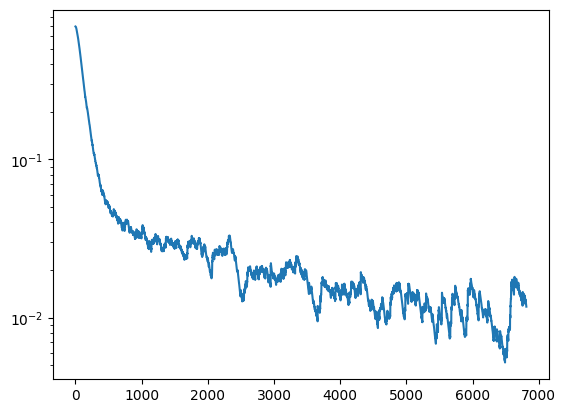

100%|██████████| 3434/3434 [01:30<00:00, 37.89it/s]


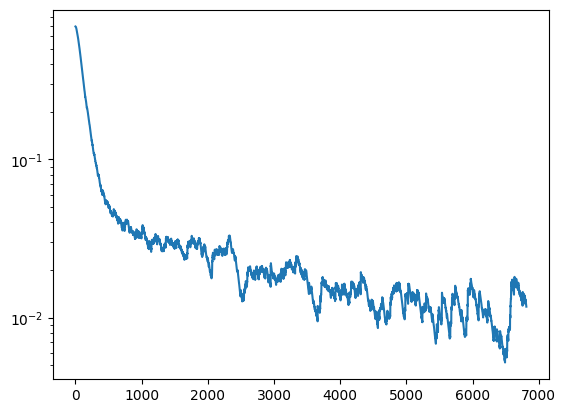

In [ ]:
### Melatih CNN Standar ###

# Hyperparameter untuk proses pelatihan
params = dict(
  batch_size = 32,         # jumlah sampel per batch
  num_epochs = 2,          # jumlah epoch (diperkecil agar proses lebih cepat)
  learning_rate = 5e-4,    # laju pembelajaran
)

# Membuat eksperimen baru di Comet untuk melacak hasil pelatihan
experiment = create_experiment("6S191_Lab2_Part2_CNN", params)

# Mendefinisikan optimizer yang akan digunakan (Adam)
optimizer = tf.keras.optimizers.Adam(params["learning_rate"])

# Mencatat dan memvisualisasikan evolusi nilai loss selama pelatihan
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')

# Membersihkan tampilan progres bar tqdm jika sudah ada
if hasattr(tqdm, '_instances'): 
  tqdm._instances.clear()

# Fungsi training step: satu langkah pembaruan parameter model
@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # Masukkan batch gambar ke dalam model untuk menghasilkan prediksi (logits)
    logits = standard_classifier(x)
    # Hitung loss menggunakan fungsi sigmoid cross entropy
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation — menghitung dan menerapkan gradien ke parameter model
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))

  return loss

# Loop utama pelatihan
step = 0
for epoch in range(params["num_epochs"]):
  for idx in tqdm(range(loader.get_train_size() // params["batch_size"])):
    # Mengambil satu batch data latih (gambar dan label)
    x, y = loader.get_batch(params["batch_size"])
    # Melakukan satu langkah training
    loss = standard_train_step(x, y)

    # Menyimpan nilai loss rata-rata untuk pelacakan
    loss_history.append(loss.numpy().mean())
    # Memperbarui grafik loss setiap beberapa detik
    plotter.plot(loss_history.get())

    # Mencatat metrik loss ke dalam Comet untuk analisis
    experiment.log_metric("loss", loss.numpy().mean(), step=step)
    step += 1


### Mengevaluasi kinerja CNN standar

Selanjutnya, mari kita evaluasi kinerja klasifikasi dari model CNN standar yang telah dilatih menggunakan dataset CelebA pada data latih.

In [ ]:
### Evaluasi CNN standar ###

# DATA LATIH
# Evaluasi pada subset dari CelebA + ImageNet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Akurasi CNN standar pada set pelatihan (berpotensi bias): {:.4f}".format(acc_standard.numpy()))

I0000 00:00:1756869631.834405   28713 service.cc:148] XLA service 0x563f48daa200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756869631.834486   28713 service.cc:156]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
I0000 00:00:1756869631.834493   28713 service.cc:156]   StreamExecutor device (1): NVIDIA L40S, Compute Capability 8.9
2025-09-03 10:20:31.858389: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 34/157 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step    

I0000 00:00:1756869632.329378   28713 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9970


Kita juga akan mengevaluasi jaringan kita pada dataset uji independen yang berisi wajah-wajah yang **tidak pernah dilihat selama pelatihan**.  
Untuk data uji ini, kita akan melihat **akurasi klasifikasi di empat demografis berbeda**, berdasarkan skala kulit *Fitzpatrick* dan label berdasarkan jenis kelamin:

- Pria berkulit gelap
- Wanita berkulit gelap
- Pria berkulit terang
- Wanita berkulit terang

Sekarang, mari kita lihat beberapa contoh wajah dari set data uji tersebut.

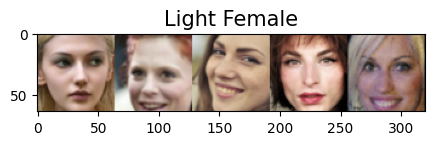

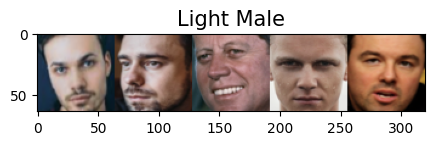

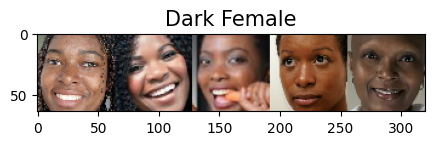

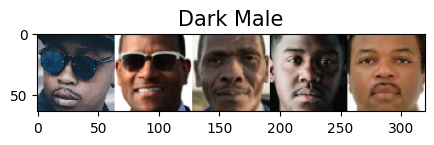

In [ ]:
### Memuat dataset uji dan menampilkan beberapa contoh ###

# Memanggil fungsi untuk mendapatkan kumpulan wajah uji
test_faces = mdl.lab2.get_test_faces()

# Menentukan empat kategori demografis berdasarkan warna kulit dan jenis kelamin
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]

# Menampilkan contoh gambar dari setiap kelompok
for group, key in zip(test_faces, keys):
  plt.figure(figsize=(5,5))           # Membuat kanvas berukuran 5x5 inci
  plt.imshow(np.hstack(group))        # Menggabungkan gambar dalam satu baris secara horizontal
  plt.title(key, fontsize=15)         # Memberikan judul pada gambar sesuai kategori


Sekarang, mari kita evaluasi probabilitas dari setiap kelompok demografis wajah tersebut untuk diklasifikasikan sebagai *wajah* menggunakan model CNN standar yang baru saja kita latih.


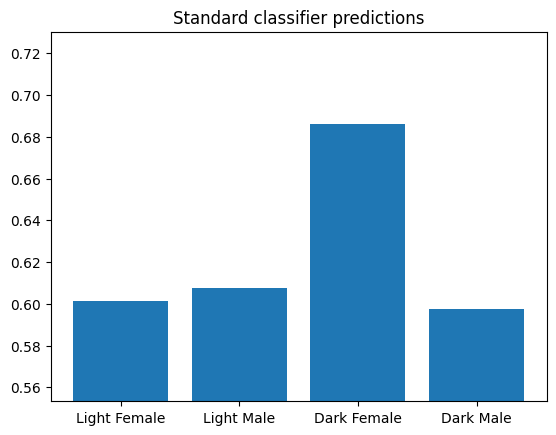

In [ ]:
### Evaluasi CNN standar pada data uji ###

# Menggunakan model CNN standar untuk memprediksi probabilitas bahwa gambar pada tiap kelompok demografis adalah wajah
standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

# Membuat plot akurasi prediksi untuk tiap demografis
xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
ptp_val = np.ptp(yy) if not hasattr(yy, "ptp") else yy.ptp()
plt.ylim(max(0, yy.min() - ptp_val / 2.), yy.max() + ptp_val / 2.)
plt.title("Prediksi classifier standar");


### Analisis hasil evaluasi CNN standar

Perhatikan nilai akurasi model pertama pada keempat kelompok demografis tersebut.  
Apakah terlihat perbedaan yang signifikan antara kelompok satu dengan lainnya?

Jika model menunjukkan tingkat akurasi yang jauh lebih tinggi pada satu kelompok (misalnya *Light Male*) dibanding kelompok lain (seperti *Dark Female*), maka model tersebut dapat dianggap **bias**.  
Bias di sini berarti model tidak memberikan performa yang seimbang untuk semua kelompok demografis.

Beberapa alasan mengapa model yang terlatih dapat memiliki akurasi yang bias antara lain:
1. **Distribusi data pelatihan yang tidak seimbang** – misalnya, dataset CelebA memiliki lebih banyak wajah dari individu berkulit terang dibanding berkulit gelap.  
2. **Representasi fitur yang terbatas** – jaringan mungkin belajar fitur yang lebih sesuai untuk satu kelompok, karena kurangnya variasi dalam data lain.  
3. **Kualitas data** – pencahayaan, resolusi, atau kontras wajah dapat berbeda antar kelompok, memengaruhi cara model belajar.  
4. **Labeling bias** – jika proses pelabelan dilakukan oleh manusia yang memiliki bias tidak sadar, hal ini dapat menular ke model.  

Dengan demikian, meskipun model memiliki akurasi tinggi secara keseluruhan, performa yang tidak merata antar kelompok menunjukkan bahwa model tersebut **tidak sepenuhnya adil atau netral**.

## 2.3 Mengurangi Bias Algoritmik

Ketidakseimbangan dalam data pelatihan dapat menyebabkan munculnya bias algoritmik yang tidak diinginkan.  
Sebagai contoh, sebagian besar wajah dalam dataset **CelebA** (yang kita gunakan untuk pelatihan) adalah wajah perempuan berkulit terang.  
Akibatnya, model klasifikasi yang dilatih dengan CelebA akan lebih baik dalam mengenali wajah dengan karakteristik serupa, dan dengan demikian menjadi **bias** terhadap kelompok tersebut.

Bagaimana kita bisa mengatasinya?

Salah satu solusi sederhana — yang kini banyak diadopsi oleh perusahaan dan organisasi — adalah dengan melakukan anotasi terhadap subkelas berbeda dalam data pelatihan  
(misalnya: perempuan berkulit terang, laki-laki dengan topi, dsb.),  
lalu menyeimbangkan jumlah data untuk setiap kelompok tersebut secara manual.

Namun, pendekatan ini memiliki dua kelemahan utama:
1. **Tidak skalabel**, karena membutuhkan anotasi terhadap jumlah data yang sangat besar.  
2. **Bergantung pada pengetahuan awal tentang jenis bias yang mungkin ada**, seperti ras, jenis kelamin, posisi wajah, atau aksesori (topi, kacamata, dll.).  
   Akibatnya, anotasi manual sering kali gagal menangkap seluruh variasi fitur yang mungkin tidak seimbang dalam data pelatihan.

Sebagai gantinya, kita akan **mempelajari fitur-fitur ini secara otomatis** dengan cara yang **tidak bias dan tidak diawasi (unsupervised)**, tanpa memerlukan anotasi sama sekali.  
Setelah itu, kita akan melatih model klasifikasi yang **adil** terhadap fitur-fitur tersebut.

Pada bagian selanjutnya dari lab ini, kita akan melakukan hal tersebut secara bertahap.

## 2.4 Variational Autoencoder (VAE) untuk Mempelajari Struktur Laten

Seperti yang telah kita lihat sebelumnya, akurasi CNN bervariasi di antara empat demografi yang kita amati.  
Untuk memahami penyebabnya, mari kita perhatikan dataset tempat model tersebut dilatih — yaitu **CelebA**.  
Jika beberapa fitur tertentu, seperti kulit gelap atau penggunaan topi, **jarang muncul** dalam CelebA, maka model akan cenderung **bias terhadap fitur-fitur langka** tersebut.  
Akibatnya, akurasi klasifikasi model akan lebih rendah pada wajah dengan fitur yang kurang terwakili (misalnya wajah berkulit gelap atau memakai topi), dibandingkan dengan wajah yang memiliki fitur yang lebih umum muncul dalam data pelatihan.  
Hal ini tentu menjadi masalah.

Tujuan kita sekarang adalah melatih versi **tidak bias (debiased)** dari model klasifikasi wajah ini —  
yakni model yang mampu mempertimbangkan ketidakseimbangan representasi fitur dalam data pelatihan.  
Secara khusus, untuk membangun klasifikator wajah yang adil, kita akan melatih model yang **mempelajari representasi dari ruang laten (latent space)** yang mendasari data wajah.  
Model ini kemudian akan menggunakan informasi tersebut untuk **mengurangi bias**, dengan cara **lebih sering melakukan sampling terhadap wajah dengan fitur langka** (seperti kulit gelap atau wajah dengan topi) selama proses pelatihan.  

Syarat utama dari model yang kita butuhkan adalah:  
model tersebut harus mampu **mempelajari pengkodean (encoding)** dari fitur-fitur laten pada data wajah **secara unsupervised** (tanpa label).  
Untuk mencapai hal ini, kita akan menggunakan **Variational Autoencoder (VAE)**.

![Konsep VAE](https://i.ibb.co/3s4S6Gc/vae.jpg)

Seperti yang terlihat pada diagram di atas (dan dijelaskan di Kuliah 4),  
VAE menggunakan arsitektur **encoder-decoder** untuk mempelajari representasi laten dari data masukan.  
Dalam konteks *computer vision*:

- **Encoder network** menerima gambar input dan mengubahnya menjadi sekelompok variabel yang didefinisikan oleh **rata-rata (mean)** dan **simpangan baku (standard deviation)**.  
  Kemudian, jaringan akan melakukan sampling dari distribusi yang dibentuk oleh dua parameter tersebut untuk menghasilkan serangkaian variabel laten.  
- **Decoder network** kemudian "mendekodekan" variabel laten tersebut untuk merekonstruksi kembali gambar asli.  
  Proses rekonstruksi ini digunakan selama pelatihan untuk membantu model mengidentifikasi variabel laten mana yang penting untuk dipelajari.

Selanjutnya, kita akan memformalkan dua aspek utama dari model VAE dan mendefinisikan fungsi yang relevan untuk masing-masing bagian tersebut.


### Memahami VAE: Fungsi Loss

Secara praktis, bagaimana cara kita melatih sebuah **Variational Autoencoder (VAE)**?

Dalam proses pembelajaran ruang laten, kita **membatasi nilai mean dan standar deviasi** agar mendekati distribusi **Gaussian satuan (unit Gaussian)**.  
Ingat bahwa nilai mean dan standar deviasi ini adalah **parameter yang dipelajari (learned parameters)**, sehingga harus diperhitungkan dalam fungsi *loss*.  
Selain itu, bagian **decoder** dari VAE menggunakan parameter-parameter ini untuk menghasilkan **rekonstruksi** yang seharusnya sangat mirip dengan gambar input aslinya — hal ini juga perlu dimasukkan ke dalam perhitungan *loss*.

Dengan demikian, fungsi *loss* pada VAE terdiri dari **dua komponen utama**:

1. **Latent loss ($L_{KL}$)**  
   Mengukur seberapa dekat variabel laten yang dipelajari terhadap distribusi Gaussian satuan.  
   Didefinisikan dengan menggunakan **Kullback-Leibler (KL) divergence)**.

2. **Reconstruction loss ($L_{x}(x,\hat{x})$)**  
   Mengukur seberapa akurat hasil rekonstruksi output ($\hat{x}$) dibandingkan dengan input asli ($x$).  
   Biasanya dihitung menggunakan **norma $L^1$** antara gambar input dan hasil rekonstruksinya.


Persamaan untuk **latent loss** diberikan oleh:

$$L_{KL}(\mu, \sigma) = \frac{1}{2}\sum_{j=0}^{k-1} (\sigma_j + \mu_j^2 - 1 - \log{\sigma_j})$$

Persamaan untuk **reconstruction loss** diberikan oleh:

$$L_{x}(x,\hat{x}) = ||x-\hat{x}||_1$$

Sehingga, fungsi *loss* total untuk **VAE** dapat dituliskan sebagai:

$$L_{VAE} = c\cdot L_{KL} + L_{x}(x,\hat{x})$$

dengan $c$ adalah **koefisien pembobot (weighting coefficient)** yang digunakan untuk **regularisasi**.

Artinya, nilai $c$ digunakan untuk menyeimbangkan pengaruh antara:
- *Latent loss* (agar distribusi ruang laten tetap menyerupai Gaussian satuan), dan  
- *Reconstruction loss* (agar hasil rekonstruksi tetap mendekati gambar aslinya).

Sekarang kita siap untuk mendefinisikan fungsi *loss* untuk model VAE.


In [ ]:
### Mendefinisikan fungsi loss untuk VAE ###

''' Fungsi untuk menghitung VAE loss berdasarkan:
      - input asli (x),
      - hasil rekonstruksi (x_recon),
      - nilai rata-rata hasil encoding (mu),
      - log dari standar deviasi hasil encoding (logsigma),
      - serta parameter pembobot untuk latent loss (kl_weight)
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  # Menghitung latent loss (L_KL)
  # Rumus ini sesuai dengan persamaan:
  # L_KL(μ, σ) = 1/2 * Σ (σ_j + μ_j^2 - 1 - log(σ_j))
  # Namun dalam TensorFlow, kita biasanya menyimpan log(σ) sebagai logsigma,
  # jadi kita perlu mengubahnya dengan tf.exp(logsigma)
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)

  # Menghitung reconstruction loss (L_x)
  # Menggunakan rata-rata perbedaan absolut (L1 norm) antar piksel
  # antara gambar asli dan hasil rekonstruksi
  # Perhitungan dilakukan pada semua dimensi gambar: tinggi, lebar, dan kanal
  reconstruction_loss = tf.reduce_mean(tf.abs(x - x_recon), axis=(1,2,3))

  # Menggabungkan keduanya menjadi total VAE loss (L_VAE)
  # L_VAE = c * L_KL + L_x
  vae_loss = kl_weight * latent_loss + reconstruction_loss

  return vae_loss


Sekarang, mari setelah memahami VAE secara konseptual, kita akan mengimplementasikannya dalam kode dan menggunakannya untuk melatih debiased facial classifier.

### Memahami VAE: Reparameterization

Seperti yang mungkin Anda ingat dari perkuliahan, VAE menggunakan "trik reparameterization" untuk melakukan sampling pada variabel laten yang telah dipelajari. Alih-alih membuat encoder VAE menghasilkan satu vektor bilangan real untuk setiap variabel laten, encoder ini menghasilkan **vektor mean (rata-rata)** dan **vektor standar deviasi** yang dikonstrain agar kurang lebih mengikuti distribusi Gaussian. 

Kita kemudian melakukan sampling dari distribusi standar deviasi tersebut dan menambahkan kembali nilai mean untuk menghasilkan **vektor laten hasil sampling**. Secara formal, untuk variabel laten $z$ dengan $\epsilon \sim N(0, I)$, kita memiliki:

$$z = \mu + e^{\left(\frac{1}{2} \cdot \log{\Sigma}\right)}\circ \epsilon$$

di mana $\mu$ adalah mean dan $\Sigma$ adalah matriks kovariansi.  
Pendekatan ini bermanfaat karena memungkinkan kita untuk dengan mudah mendefinisikan fungsi loss untuk VAE, menghasilkan variabel laten yang diambil secara acak, meningkatkan generalisasi jaringan, **dan** membuat seluruh jaringan VAE menjadi *differentiable*, sehingga dapat dilatih menggunakan *backpropagation*.  
Cukup kuat, bukan?

Mari kita definisikan fungsi untuk mengimplementasikan operasi sampling pada VAE:


In [ ]:
### VAE Reparameterization ###

"""Trik reparameterisasi dengan melakukan sampling dari distribusi Gaussian isotropik satuan.
# Argumen:
    z_mean, z_logsigma (tensor): mean dan log dari standar deviasi distribusi laten (Q(z|X))
# Keluaran:
    z (tensor): vektor laten hasil sampling
"""
def sampling(z_mean, z_logsigma):
  # Secara default, random.normal menghasilkan distribusi "standar" (mean=0 dan std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  # Implementasi rumus reparameterisasi:
  # z = μ + exp(0.5 * log(Σ)) * ε
  # di mana:
  # μ (z_mean) = mean dari distribusi laten
  # Σ (z_logsigma) = log dari varians (bukan log dari standar deviasi)
  # ε = noise acak yang diambil dari distribusi normal standar
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  return z


## 2.5 Debiasing variational autoencoder (DB-VAE)

Sekarang, kita akan menggunakan ide umum dari arsitektur VAE untuk membangun sebuah model yang disebut [*debiasing variational autoencoder*](https://lmrt.mit.edu/sites/default/files/AIES-19_paper_220.pdf) atau disingkat **DB-VAE**, untuk mengurangi bias (yang mungkin tidak diketahui) yang terdapat dalam data pelatihan.  
Kita akan melatih model DB-VAE ini pada tugas deteksi wajah, menjalankan proses *de-biasing* selama pelatihan, mengevaluasi performanya pada dataset PPB, dan membandingkan akurasinya dengan model CNN asli yang sebelumnya terbukti bias.

### Model DB-VAE

Gagasan utama di balik pendekatan *debiasing* ini adalah menggunakan variabel laten yang dipelajari melalui VAE untuk menyesuaikan kembali proses *sampling* data CelebA selama pelatihan.  
Secara khusus, kita akan mengubah probabilitas bahwa sebuah gambar digunakan dalam pelatihan berdasarkan seberapa sering fitur laten gambar tersebut muncul di dataset.  

Dengan kata lain:
- Wajah dengan fitur **langka** (misalnya kulit gelap, memakai kacamata hitam, atau topi) akan **lebih sering** diambil selama pelatihan.  
- Wajah dengan fitur yang **berlebihan jumlahnya** di dataset pelatihan akan memiliki probabilitas sampling yang **lebih rendah** (dibandingkan dengan probabilitas sampling acak yang seragam di seluruh data pelatihan).

Diagram umum dari pendekatan DB-VAE ditunjukkan pada gambar berikut:

![DB-VAE](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2019/lab2/img/DB-VAE.png)


Ingat bahwa kita ingin menerapkan DB-VAE kita pada sebuah masalah *supervised classification* — yaitu tugas deteksi wajah.  
Hal penting yang perlu diperhatikan adalah bahwa bagian *encoder* dalam arsitektur DB-VAE juga menghasilkan satu variabel terawasi, yaitu $z_o$, yang berfungsi sebagai prediksi kelas — apakah gambar tersebut **wajah** atau **bukan wajah**.  

Biasanya, VAE **tidak dilatih untuk menghasilkan variabel terawasi** seperti prediksi kelas!  
Inilah perbedaan utama lainnya antara **DB-VAE** dan **VAE tradisional**.

Perlu diingat bahwa kita hanya ingin mempelajari representasi laten untuk **gambar wajah saja**, karena itulah yang menjadi fokus proses *de-biasing*, meskipun model kita dilatih pada masalah klasifikasi biner (wajah vs. bukan wajah).  

Oleh karena itu, kita harus memastikan bahwa:
- **Untuk gambar wajah**, model DB-VAE harus mempelajari representasi dari variabel laten tak terawasi (dilambangkan dengan distribusi $q_\phi(z|x)$), **dan** sekaligus menghasilkan variabel terawasi $z_o$ sebagai prediksi kelas.  
- **Untuk gambar bukan wajah**, model hanya perlu menghasilkan prediksi kelas $z_o$ tanpa mempelajari representasi laten.


### Mendefinisikan Fungsi Loss DB-VAE

Artinya, kita perlu sedikit cermat dalam merancang fungsi *loss* untuk model DB-VAE.  
Bentuk fungsi *loss* ini akan bergantung pada apakah gambar yang diproses merupakan **wajah** atau **bukan wajah**.

Untuk **gambar wajah**, fungsi *loss* akan memiliki dua komponen utama:

1. **VAE loss ($L_{VAE}$)** — terdiri dari *latent loss* dan *reconstruction loss*.  
2. **Classification loss ($L_y(y,\hat{y})$)** — yaitu *cross-entropy loss* standar yang digunakan untuk masalah klasifikasi biner.

Sebaliknya, untuk **gambar bukan wajah**, fungsi *loss* hanya mencakup *classification loss* saja.

Kita dapat menulis satu persamaan umum untuk menggabungkan keduanya dengan mendefinisikan variabel indikator ${I}_f$,  
yang menunjukkan data pelatihan mana yang merupakan gambar wajah (${I}_f(y) = 1$) dan mana yang bukan (${I}_f(y) = 0$).  
Dengan demikian, persamaan totalnya menjadi:

$$L_{total} = L_y(y,\hat{y}) + {I}_f(y)\Big[L_{VAE}\Big]$$

Selanjutnya, kita akan menulis fungsi Python untuk mendefinisikan fungsi *loss* dari DB-VAE ini.


In [ ]:
### Fungsi Loss untuk DB-VAE ###

"""Fungsi loss untuk DB-VAE.
# Argumen
    x: input asli (citra wajah atau bukan wajah)
    x_pred: hasil rekonstruksi dari input
    y: label sebenarnya (1 = wajah, 0 = bukan wajah)
    y_logit: prediksi label dari model (sebelum aktivasi sigmoid)
    mu: nilai mean dari distribusi laten Q(z|X)
    logsigma: log dari standar deviasi distribusi laten Q(z|X)
# Mengembalikan
    total_loss: total loss DB-VAE
    classification_loss: komponen loss klasifikasi DB-VAE
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  # Memanggil fungsi yang sudah dibuat sebelumnya untuk menghitung VAE loss
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  # Fungsi ini menghitung gabungan dari latent loss dan reconstruction loss.

  # Mendefinisikan loss untuk klasifikasi menggunakan sigmoid cross-entropy
  # Fungsi ini mengukur selisih antara label sebenarnya (y)
  # dan output prediksi (y_logit) dalam konteks klasifikasi biner.
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)

  # Membuat indikator wajah (face indicator)
  # Jika data adalah wajah (y=1), maka indikator bernilai 1; jika bukan wajah, bernilai 0.
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # Menggabungkan kedua komponen loss:
  # 1. classification_loss: untuk semua data (baik wajah maupun bukan wajah)
  # 2. vae_loss: hanya dihitung untuk data wajah (dikendalikan oleh face_indicator)
  # Lalu dihitung rata-ratanya menggunakan tf.reduce_mean.
  total_loss = tf.reduce_mean(
      classification_loss +
      face_indicator * vae_loss
  )

  return total_loss, classification_loss


### Arsitektur DB-VAE

Sekarang kita siap untuk mendefinisikan arsitektur **DB-VAE (Debiasing Variational Autoencoder)**.  
Untuk membangun DB-VAE, kita akan menggunakan **CNN standar** yang sudah dibuat sebelumnya sebagai *encoder*, lalu mendefinisikan jaringan **decoder** baru.  
Kedua bagian ini — *encoder* dan *decoder* — akan digabungkan menjadi satu model *end-to-end* berbasis VAE.

Kita akan menggunakan **ruang laten (latent space)** dengan **100 variabel laten**.

In [ ]:
### Mendefinisikan bagian decoder dari DB-VAE ###

n_filters = 12  # jumlah dasar filter konvolusional, sama seperti CNN standar
latent_dim = 100  # jumlah variabel laten yang akan digunakan

def make_face_decoder_network():
  # Secara fungsional mendefinisikan tipe-tipe layer yang akan digunakan
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Membangun jaringan decoder menggunakan Sequential API
  decoder = tf.keras.Sequential([
    # Mengubah vektor laten menjadi bentuk fitur 4x4 sebelum konvolusi transpos
    Dense(units=4*4*6*n_filters),  # menghasilkan peta fitur berukuran 4x4 dengan 6*n_filters channel
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Lapisan konvolusi transpos (kebalikan dari encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3, strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3, strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5, strides=2),
    Conv2DTranspose(filters=3, kernel_size=5, strides=2),  # output RGB (3 channel)
  ])

  return decoder


Sekarang, kita akan menggabungkan *decoder* ini dengan *CNN classifier* standar sebagai *encoder* untuk membentuk model **DB-VAE**.  
Perlu diperhatikan bahwa hingga tahap ini, belum ada hal khusus dalam cara kita menyusun model yang menjadikannya sebagai model “*debiasing*” — bagian itu baru akan diterapkan saat kita mendefinisikan proses pelatihannya nanti.  

Di sini, kita akan mendefinisikan arsitektur inti dari **VAE** dengan cara menurunkan (*subclassing*) kelas `Model`, kemudian mendefinisikan operasi **encoding**, **reparameterization**, dan **decoding**, serta menjalankan jaringan ini secara end-to-end.


In [ ]:
### Mendefinisikan dan Membuat Arsitektur DB-VAE ###

class DB_VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(DB_VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder akan menghasilkan sejumlah output yang terdiri dari:
        # - 2 * latent_dim (karena tiap variabel laten punya mean dan log(sigma))
        # - 1 output tambahan untuk prediksi klasifikasi (face / non-face)
        num_encoder_dims = 2 * self.latent_dim + 1

        # Encoder menggunakan CNN standar, dan decoder menggunakan jaringan pembangkit wajah (face decoder)
        self.encoder = make_standard_classifier(num_encoder_dims)
        self.decoder = make_face_decoder_network()

    # Fungsi encode:
    # Menerima gambar input, melewatkannya ke encoder, lalu memisahkan hasilnya menjadi
    # 1) logit klasifikasi (y_logit),
    # 2) mean (z_mean), dan
    # 3) log(sigma) (z_logsigma) dari distribusi laten.
    def encode(self, x):
        encoder_output = self.encoder(x)

        # Keluaran pertama adalah logit prediksi kelas
        y_logit = tf.expand_dims(encoder_output[:, 0], -1)

        # Bagian berikutnya adalah mean dan log-sigma untuk variabel laten
        z_mean = encoder_output[:, 1:self.latent_dim + 1]
        z_logsigma = encoder_output[:, self.latent_dim + 1:]

        return y_logit, z_mean, z_logsigma

    # Fungsi reparameterisasi:
    # Menggunakan mean dan log-sigma untuk mengambil sampel z dari distribusi Gaussian menggunakan trik reparameterisasi.
    def reparameterize(self, z_mean, z_logsigma):
        z = sampling(z_mean, z_logsigma)
        return z

    # Fungsi decode:
    # Menggunakan decoder untuk merekonstruksi kembali gambar berdasarkan variabel laten z.
    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    # Fungsi call:
    # Menghubungkan seluruh proses: encoding → sampling (reparameterisasi) → decoding.
    # Ini merupakan alur end-to-end dari DB-VAE.
    def call(self, x):
        # Langkah 1: Encoding
        y_logit, z_mean, z_logsigma = self.encode(x)

        # Langkah 2: Reparameterisasi
        z = self.reparameterize(z_mean, z_logsigma)

        # Langkah 3: Rekonstruksi
        recon = self.decode(z)

        # Mengembalikan hasil utama
        return y_logit, z_mean, z_logsigma, recon

    # Fungsi prediksi:
    # Menghasilkan logit klasifikasi (face / non-face) tanpa melakukan decoding.
    def predict(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x)
        return y_logit


# Inisialisasi model DB-VAE dengan jumlah dimensi laten tertentu
dbvae = DB_VAE(latent_dim)


Seperti disebutkan, arsitektur encoder identik dengan CNN yang dibuat sebelumnya dalam lab ini.  
Perhatikan keluaran dari model `DB_VAE` yang kita definisikan pada fungsi `call`: `y_logit, z_mean, z_logsigma, z`.  
Pikirkan baik-baik mengapa masing-masing nilai ini dikembalikan dan apa signifikansinya terhadap masalah yang sedang kita hadapi.

- `y_logit` : logit untuk prediksi klasifikasi (wajah atau bukan wajah). Digunakan untuk menghitung classification loss dan melakukan prediksi akhir setelah diterapkan fungsi sigmoid.
- `z_mean` : vektor mean dari distribusi laten yang dipelajari encoder; diperlukan untuk menghitung KL loss dan juga untuk analisis struktur laten.
- `z_logsigma` : log dari varians/standar deviasi distribusi laten; bersama `z_mean` ini digunakan dalam reparameterization trick untuk sampling dan juga masuk ke komponen latent loss.
- `z` : vektor laten yang disampel (hasil reparameterisasi). Digunakan sebagai input ke decoder untuk merekonstruksi gambar dan untuk membentuk distribusi latent yang akan dipakai dalam operasi debiasing (mis. menghitung frekuensi fitur laten).

Memahami peran masing-masing keluaran ini penting karena:
- `y_logit` mengikat bagian supervised dari model (klasifikasi),
- `z_mean` dan `z_logsigma` mengontrol bagaimana ruang laten dibentuk dan diregulasi (melalui KL loss),
- `z` memungkinkan rekonstruksi serta penilaian seberapa umum/rare sebuah representasi laten sehingga dapat dipakai untuk adaptive re-sampling saat debiasing.


### Resampling Adaptif untuk Debiasing Otomatis dengan DB-VAE

Jadi, bagaimana cara kita benar-benar menggunakan **DB-VAE** untuk melatih *facial detection classifier* yang tidak bias?

Ingat kembali arsitektur DB-VAE: ketika citra masukan melewati jaringan, **encoder** mempelajari perkiraan distribusi ${Q}(z|X)$ pada ruang laten.  
Tujuan kita adalah **meningkatkan frekuensi relatif dari data yang langka** dengan cara meningkatkan probabilitas sampling dari **wilayah ruang laten yang kurang terwakili**.

Kita dapat memperkirakan ${Q}(z|X)$ dengan menggunakan **distribusi frekuensi dari setiap variabel laten** yang dipelajari, lalu mendefinisikan **distribusi probabilitas** untuk memilih suatu titik data $x$ berdasarkan pendekatan ini.  
Distribusi probabilitas ini kemudian digunakan selama pelatihan untuk melakukan **re-sampling data secara adaptif** — meningkatkan peluang munculnya contoh dengan fitur-fitur wajah yang jarang muncul (misalnya warna kulit gelap, penggunaan kacamata, atau pose yang tidak umum).

Dengan kata lain, DB-VAE menggunakan struktur latennya untuk **mengidentifikasi dan menyeimbangkan representasi fitur** secara otomatis, tanpa perlu anotasi manual tentang kelompok demografis atau karakteristik wajah tertentu.

Selanjutnya, kamu akan menulis fungsi untuk memperbarui probabilitas sampling ini, dan memanggil fungsi tersebut di dalam **loop pelatihan DB-VAE** agar model benar-benar menjadi *debiased* selama proses training.


Pertama, kita mendefinisikan sebuah fungsi pembantu sederhana bernama `get_latent_mu`,  
yang berfungsi untuk **mengembalikan nilai rata-rata (mean)** dari variabel laten (`latent variable means`)  
yang dihasilkan oleh *encoder* setelah satu batch citra dimasukkan ke dalam jaringan:


In [ ]:
# Fungsi untuk mengembalikan nilai mean (μ) dari variabel laten untuk satu batch gambar
def get_latent_mu(images, dbvae, batch_size=1024):
    # N menyimpan jumlah total gambar dalam dataset yang diberikan
    N = images.shape[0]
    
    # Inisialisasi array kosong untuk menyimpan hasil nilai mean dari setiap gambar
    mu = np.zeros((N, latent_dim))
    
    # Looping dilakukan secara bertahap berdasarkan ukuran batch agar efisien secara memori
    for start_ind in range(0, N, batch_size):
        end_ind = min(start_ind + batch_size, N + 1)  # pastikan indeks tidak melewati jumlah data
        
        # Normalisasi batch gambar ke rentang [0,1] dengan membagi nilai pixel 255
        batch = (images[start_ind:end_ind]).astype(np.float32) / 255.
        
        # Melalui encoder DB-VAE untuk mendapatkan parameter distribusi laten
        # encoder mengembalikan: y_logit (prediksi kelas), batch_mu (mean), dan batch_logsigma (log standar deviasi)
        _, batch_mu, _ = dbvae.encode(batch)
        
        # Simpan nilai mean ke dalam array mu sesuai posisi batch
        mu[start_ind:end_ind] = batch_mu
    
    # Kembalikan seluruh mean dari distribusi laten untuk semua gambar
    return mu


Sekarang, mari kita definisikan algoritma *resampling* sebenarnya, yaitu `get_training_sample_probabilities`.  
Perhatikan bahwa terdapat argumen penting bernama `smoothing_fac`.  
Parameter ini mengatur **tingkat debiasing** yang diterapkan:  
jika `smoothing_fac=0`, maka himpunan data pelatihan yang di-*resample* akan cenderung tersebar **secara seragam** di seluruh ruang laten (*latent space*),  
artinya terjadi proses *debiasing* yang paling ekstrem (semua variasi laten dianggap memiliki peluang yang sama untuk dipilih).


In [ ]:
### Algoritma Resampling untuk DB-VAE ###

'''Fungsi yang menghitung ulang probabilitas sampling untuk gambar dalam satu batch
       berdasarkan bagaimana gambar-gambar tersebut terdistribusi di seluruh data pelatihan'''
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    print("Menghitung ulang probabilitas sampling")

    # TODO: jalankan input batch dan dapatkan rata-rata variabel laten (mu)
    mu = get_latent_mu(images, dbvae)
    # mu = get_latent_mu('''TODO''') # TODO

    # probabilitas sampling untuk gambar-gambar
    training_sample_p = np.zeros(mu.shape[0])

    # pertimbangkan distribusi untuk setiap variabel laten
    for i in range(latent_dim):

        latent_distribution = mu[:,i]
        # buat histogram dari distribusi laten
        hist_density, bin_edges = np.histogram(latent_distribution, density=True, bins=bins)

        # temukan di bin laten mana setiap sampel data jatuh
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')

        # TODO: panggil fungsi digitize untuk menemukan di bin mana dalam distribusi laten
        #       setiap sampel data jatuh
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_idx = np.digitize(latent_distribution, bin_edges)
        # bin_idx = np.digitize('''TODO''', '''TODO''') # TODO

        # ratakan (smooth) fungsi densitas
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # balikkan (invert) fungsi densitas
        p = 1.0/(hist_smoothed_density[bin_idx-1])

        # TODO: normalisasi semua probabilitas
        p = p / np.sum(p)
        # p = # TODO

        # TODO: perbarui probabilitas sampling dengan mempertimbangkan apakah p yang baru
        #       dihitung lebih besar dari probabilitas sampling yang sudah ada.
        training_sample_p = np.maximum(p, training_sample_p)
        # training_sample_p = # TODO

    # normalisasi akhir
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Sekarang setelah kita mendefinisikan pembaruan *resampling*, kita dapat melatih model DB-VAE kita pada data pelatihan CelebA/ImageNet, dan menjalankan operasi di atas untuk menimbang ulang (re-weight) kepentingan titik data tertentu saat kita melatih model. Ingat kembali bahwa kita hanya ingin menghilangkan bias (*debias*) untuk fitur yang relevan dengan *wajah*, bukan set contoh negatif. Selesaikan blok kode di bawah ini untuk menjalankan *training loop* (perulangan pelatihan)!

Starting epoch 1/1
Recomputing the sampling probabilities


100%|██████████| 3434/3434 [01:37<00:00, 35.05it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : regular_scorpion_1148
COMET INFO:     url                   : https://www.comet.com/sigitpurnomo/6s191-lab2-part2-dbvae/fd0a9b31c1bf4a2eaa595df57c87ac78
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3434] : (0.05722562596201897, 0.9293461441993713)
COMET INFO:   Parameters:
COMET INFO:     Optimizer                        : adam
COMET INFO:     adam_amsgrad                     : False
COMET INFO:     adam_beta_1                      : 0.9
COMET INFO:     adam_beta_2                      : 0.999
COMET INFO:     adam_clipnorm                    : None
COMET INFO:     adam_clipvalue  

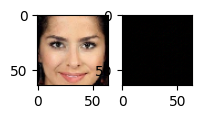

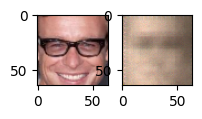

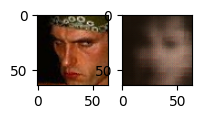

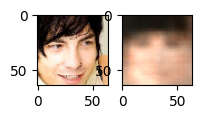

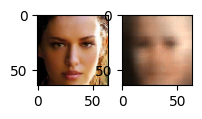

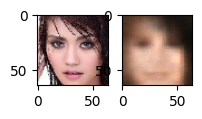

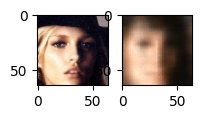

In [ ]:
### Melatih DB-VAE ###

# Hyperparameter
params = dict(
    batch_size = 32, # Ukuran batch, jumlah sampel yang diproses sebelum model diperbarui
    learning_rate = 5e-4, # Tingkat pembelajaran untuk optimizer Adam
    latent_dim = 100, # Dimensi ruang laten (z)
    num_epochs = 1, # Jumlah epoch (iterasi lengkap melalui seluruh dataset)
)

experiment = create_experiment("6S191_Lab2_Part2_DBVAE", params)

# Instansiasi model DB-VAE dan optimizer baru
dbvae = DB_VAE(params["latent_dim"]) # Membuat instance model
optimizer = tf.keras.optimizers.Adam(params["learning_rate"]) # Menggunakan optimizer Adam

# Untuk mendefinisikan operasi pelatihan, kita akan menggunakan tf.function, yang merupakan alat canggih
# yang memungkinkan kita mengubah fungsi Python menjadi graf komputasi TensorFlow.
@tf.function
def debiasing_train_step(x, y):
    # Menggunakan tf.GradientTape untuk merekam operasi yang diperlukan untuk menghitung gradien
    with tf.GradientTape() as tape:
        # Masukkan input x ke dbvae. Perhatikan bahwa ini memanggil fungsi call dari kelas DB_VAE!
        y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

        '''TODO: panggil fungsi kerugian (loss function) DB_VAE untuk menghitung kerugian'''
        # Fungsi kerugian menggabungkan: VAE loss (rekonstruksi + KL divergence) dan Classification loss
        loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
        # loss, class_loss = debiasing_loss_function('''argumen TODO''') # TODO

    '''TODO: gunakan metode GradientTape.gradient untuk menghitung gradien.
        Petunjuk: ini sehubungan dengan variabel yang dapat dilatih (trainable_variables) dari dbvae.'''
    # Menghitung gradien kerugian terhadap semua variabel model yang dapat dilatih
    grads = tape.gradient(loss, dbvae.trainable_variables)
    # grads = tape.gradient('''TODO''', '''TODO''') # TODO

    # Terapkan gradien ke variabel (melakukan pembaruan bobot)
    optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
    return loss

# Dapatkan semua wajah pelatihan dari data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # bersihkan jika ada

# Perulangan pelatihan (The training loop) -- perulangan luar beriterasi selama jumlah epoch
step = 0
for i in range(params["num_epochs"]):

    IPython.display.clear_output(wait=True)
    print("Memulai epoch {}/{}".format(i+1, params["num_epochs"]))

    # Hitung ulang probabilitas sampling data
    '''TODO: hitung ulang probabilitas sampling untuk debiasing'''
    # Menggunakan algoritma resampling (get_training_sample_probabilities) untuk menghitung bobot p_faces.
    p_faces = get_training_sample_probabilities(all_faces, dbvae)
    # p_faces = get_training_sample_probabilities('''TODO''', '''TODO''') # TODO

    # Dapatkan satu batch data pelatihan dan hitung langkah pelatihan
    for j in tqdm(range(loader.get_train_size() // params["batch_size"])):
        # Muat satu batch data
        # Data loader menggunakan p_faces (bobot yang dibangkitkan DB-VAE) saat mengambil batch.
        (x, y) = loader.get_batch(params["batch_size"], p_pos=p_faces)

        # Optimasi kerugian
        loss = debiasing_train_step(x, y)
        experiment.log_metric("loss", loss.numpy().mean(), step=step)

        # plot kemajuan setiap 500 langkah
        if j % 500 == 0:
            mdl.util.plot_sample(x, y, dbvae)

        step += 1

experiment.end()

Luar biasa! Sekarang kita seharusnya sudah memiliki model klasifikasi wajah yang terlatih dan (semoga!) sudah terbebas dari bias (*debiased*), siap untuk dievaluasi!

## 2.6 Evaluasi DB-VAE pada Dataset Uji (Test Dataset)

Akhirnya, mari kita uji model **DB-VAE** kita pada dataset uji, melihat secara spesifik akurasinya pada setiap demografi "Pria Gelap", "Wanita Gelap", "Pria Terang", dan "Wanita Terang". Kita akan membandingkan kinerja model yang sudah **dihilangkan biasnya (*debiased*)** ini dengan **CNN standar** (yang berpotensi bias) dari awal lab.

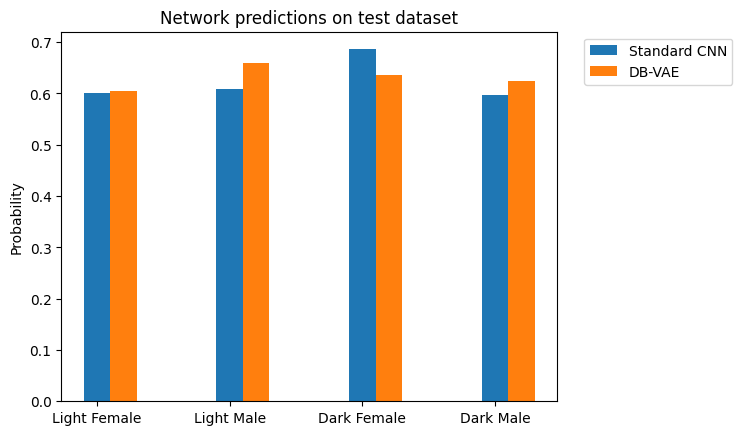

In [ ]:
# Menganalisis Prediksi Model pada Dataset Uji

# Jalankan model DB-VAE pada setiap sub-grup demografi di dataset uji (test_faces).
# dbvae.predict mengembalikan logit (output sebelum fungsi aktivasi sigmoid)
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]

# Ubah logit DB-VAE menjadi probabilitas menggunakan fungsi sigmoid,
# kemudian hapus dimensi tunggal (misalnya, dari (N, 1) menjadi (N,)).
# Probabilitas ini mewakili keyakinan model terhadap fitur target (misalnya, 'berwajah').
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

# Siapkan sumbu x untuk plot (misalnya, [0, 1, 2, 3] untuk empat sub-grup demografi)
xx = np.arange(len(keys))

# Plot bar chart untuk hasil Standard CNN
# standard_classifier_probs.numpy().mean(1) menghitung rata-rata probabilitas
# (akibatnya, akurasi) di sepanjang sumbu 1 (per sub-grup) untuk CNN standar.
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")

# Plot bar chart untuk hasil DB-VAE, digeser sebesar 0.2 di sumbu x
# dbvae_probs.numpy().mean(1) menghitung rata-rata probabilitas (akurasi)
# di sepanjang sumbu 1 untuk model DB-VAE yang sudah di-debias.
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")

# Atur label sumbu x menggunakan nama-nama sub-grup demografi (keys)
plt.xticks(xx, keys);

# Berikan judul pada plot
plt.title("Prediksi Jaringan pada Dataset Uji")

# Beri label pada sumbu y dan tambahkan legenda di luar plot
plt.ylabel("Probabilitas"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");

<img src="https://i.ibb.co/BjLSRMM/ezgif-2-253dfd3f9097.gif" />